### Links

[Про оптимизацию Learning rate в PyTorch](https://colab.research.google.com/drive/1tzCqv5uAe4U8Bhk4sr-FV6paaGOWfb_7#scrollTo=JBBDG1hzyW-8&line=1&uniqifier=1)

[LambdaLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.LambdaLR.html#torch.optim.lr_scheduler.LambdaLR)

[MultiStepLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.MultiStepLR.html#torch.optim.lr_scheduler.MultiStepLR)

[StepLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.StepLR.html#torch.optim.lr_scheduler.StepLR)

[ExponentialLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ExponentialLR.html#exponentiallr)

[ReduceLROnPlateau](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html#torch.optim.lr_scheduler.ReduceLROnPlateau)

### Imports

In [2]:
import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader, random_split

import torchvision
from torchvision.transforms import v2

import os
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
import numpy as np

import json
from tqdm import tqdm
from PIL import Image

plt.style.use('dark_background')

### Создание данных для задачи регрессии

#### Необходимые импорты для создания данных

In [65]:
import struct
import sys

from array import array
from os import path

#### Данные для Регрессии

In [66]:
if not os.path.isdir("dataset"):
    os.mkdir('dataset')

img = np.random.randint(0, 50, [100000, 64, 64], dtype=np.uint8)
square = np.random.randint(100, 200, [100000, 15, 15], dtype=np.uint8)

coords = np.empty([100000, 2])

data = {}

for i in range(img.shape[0]):
    x = np.random.randint(20, 44)
    y = np.random.randint(20, 44)

    img[i, (y-7):(y + 8), (x - 7):(x + 8)] = square[i]

    coords[i] = [y, x]

    name_img = f'img{i}.jpeg'
    path_img = os.path.join('dataset/', name_img)

    image = Image.fromarray(img[i])
    image.save(path_img)

    data[name_img] = [y, x]

with open('dataset/coords.json', 'w') as f:
    json.dump(data, f, indent=2)

# os.rmdir('dataset/.ipymb_checpoints')

### LearningRate Schduler

Предназначен для изменения скорости обучения в процессе обучния.

#### Подготовка для рассмотрения шедулеров

In [5]:
# создаем простую модель для демонстрации работы шедулера
class MyModel(nn.Module):
    def __init__(self, input, output):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input, 128),
            nn.ReLU(),
            nn.Linear(128, output)
        )

    def forward(self, x):
        return self.model(x)

In [6]:
model = MyModel(784, 10)

loss_model = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr = 0.1)

#### [Lambda LR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.LambdaLR.html#torch.optim.lr_scheduler.LambdaLR)

Корректировка LR с помощью лябда функции

LambdaLR (Lambda Learning Rate Scheduler) - это планировщик скорости обучения в PyTorch, который позволяет динамически изменять скорость обучения во время тренировки модели на основе функции, которую вы определяете. Вместо использования фиксированной скорости обучения или простых схем уменьшения, таких как ступенчатое уменьшение, LambdaLR предлагает большую гибкость.

Как он работает?

LambdaLR принимает функцию lambda, которая принимает текущую эпоху (или номер шага) в качестве входных данных и возвращает множитель, на который будет умножена начальная скорость обучения. Этот множитель определяет, насколько нужно увеличить или уменьшить скорость обучения на данной эпохе.

Преимущества LambdaLR:

- Гибкость: Позволяет реализовать любую стратегию изменения скорости обучения, которую можно выразить в виде функции.

- Простота: Легко использовать и настраивать.

- Контроль: Полный контроль над процессом изменения скорости обучения.

Когда использовать LambdaLR:

- Сложные стратегии: Когда требуется нестандартная схема изменения скорости обучения, которая не покрывается другими планировщиками.

- Тонкая настройка: Для точной настройки скорости обучения под конкретную задачу.

- Циклическое обучение: Реализация циклических изменений скорости обучения (cyclical learning rates).

- Warmup: Постепенное увеличение скорости обучения в начале тренировки.

В заключение: LambdaLR - мощный инструмент для управления скоростью обучения в PyTorch. Его гибкость и простота делают его отличным выбором для различных задач машинного обучения. Он позволяет реализовать практически любую стратегию изменения learning rate, что может существенно повлиять на качество и скорость обучения модели.

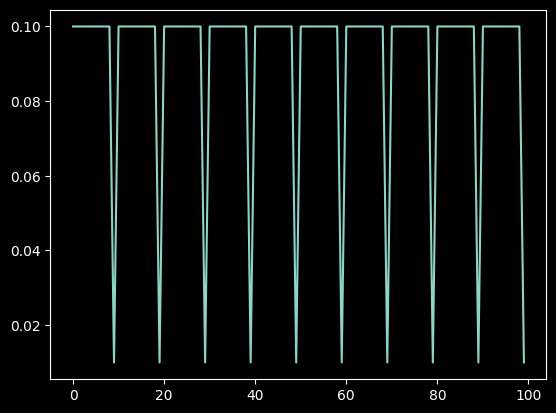

In [7]:
lr_lambda = lambda step: 0.1 if step % 10 == 0 else 1
lr_scheduler = torch.optim.lr_scheduler.LambdaLR(opt, lr_lambda=lr_lambda)

# Подобие цикла обучения
MyList = []
for epoch in range(100):

    # Train
    for _ in range(1):
        # forward pass
        # backward pass
        opt.step()


    # Validation
        # forward pass

    lr_scheduler.step()
    lr = lr_scheduler.get_last_lr()
    MyList.append(lr)

plt.plot(MyList)
plt.show()

На графике видно, что первые 9 итераций скорость не менялась, затем, она была домножен на 0.1. На 11ой итерации, снова была возвращена к единице.

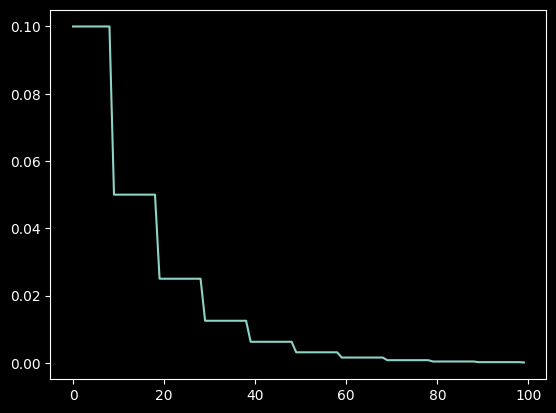

In [15]:
def lr_lambda(epoch):
  if epoch < 10:
    return 1  # Без изменений в первые 10 эпох
  else:
    return 0.5 ** (epoch // 10) # Уменьшение в 10 раз каждые 10 эпох

lr_scheduler = torch.optim.lr_scheduler.LambdaLR(opt, lr_lambda=lr_lambda)

# Подобие цикла обучения
MyList = []
for epoch in range(100):

    # Train
    for _ in range(1):
        # forward pass
        # backward pass
        opt.step()


    # Validation
        # forward pass

    lr_scheduler.step()
    lr = lr_scheduler.get_last_lr()
    MyList.append(lr)

plt.plot(MyList)
plt.show()

В этом примере:

- В первые 10 эпох скорость обучения остается неизменной (множитель 1).

- После 10-й эпохи скорость обучения уменьшается в 2 раза каждые 10 эпох (например, на 10-й эпохе - 0.5, на 20-й - 0.25 и т.д.).

#### [MultiStepLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.MultiStepLR.html#torch.optim.lr_scheduler.MultiStepLR)

`MultiStepLR` - это планировщик скорости обучения в PyTorch, который уменьшает скорость обучения на определенный коэффициент (гамма) в заданные эпохи. В отличие от `StepLR`, который уменьшает скорость обучения через равные интервалы, `MultiStepLR` позволяет задать список конкретных эпох, на которых будет происходить уменьшение.

**Как он работает?**

`MultiStepLR` принимает три основных аргумента:

* `optimizer`: Оптимизатор, для которого нужно изменять скорость обучения.
* `milestones`: Список эпох (индексы начинаются с 0), на которых нужно уменьшить скорость обучения.  **Важно:** Список `milestones` должен быть отсортирован по возрастанию.
* `gamma`: Множитель, на который будет умножена текущая скорость обучения при достижении эпохи из списка `milestones`.  Обычно `gamma` меньше 1 (например, 0.1).  Это означает, что скорость обучения будет уменьшаться.

**Преимущества MultiStepLR:**

* **Простота:** Легко использовать и настраивать.
* **Гибкость в выборе эпох:** Позволяет задавать произвольные эпохи для уменьшения скорости обучения, что может быть полезно, если известно, когда модель начинает переобучаться.


**Когда использовать MultiStepLR:**

* **Стандартные задачи:** Хорошо подходит для многих задач, где требуется уменьшить скорость обучения в несколько этапов.
* **Известные точки переобучения:**  Если из предыдущих экспериментов или анализа данных известно, на каких эпохах модель начинает переобучаться, можно задать эти эпохи в `milestones`.

**Недостатки:**

* **Ручная настройка:** Требует ручного подбора `milestones` и `gamma`, что может потребовать экспериментов.  Неправильный выбор `milestones` может привести к плохой производительности модели.


**В заключение:** `MultiStepLR` - простой и эффективный планировщик скорости обучения, который хорошо подходит для многих задач. Он позволяет гибко управлять уменьшением скорости обучения в заданные моменты времени, но требует careful подбора параметров `milestones` и `gamma`.  Если вы не знаете, какие эпохи выбрать, можно начать с общих рекомендаций (например, уменьшать скорость обучения в 2-10 раз каждые несколько десятков эпох) и затем подстроить параметры на основе результатов экспериментов.


Эпохи на которых изменится LR: [10, 20, 30, 40, 50, 60, 70, 80, 90]


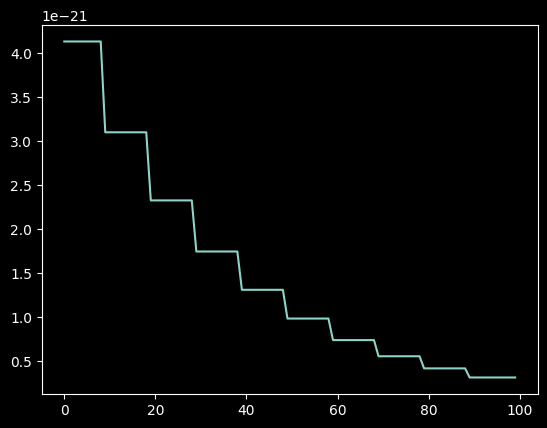

In [31]:
milestones = [x for x in range(10,100,10)]
print(f'Эпохи на которых изменится LR: {milestones}')

lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(opt, milestones=milestones, gamma=0.75)

# Подобие цикла обучения
MyList = []
for epoch in range(100):

    # Train
    for _ in range(1):
        # forward pass
        # backward pass
        opt.step()


    # Validation
        # forward pass

    lr_scheduler.step()
    lr = lr_scheduler.get_last_lr()
    MyList.append(lr)

plt.plot(MyList)
plt.show()

#### [StepLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.StepLR.html#torch.optim.lr_scheduler.StepLR)

`StepLR` - это планировщик скорости обучения в PyTorch, который уменьшает скорость обучения на заданный коэффициент (`gamma`) через определенное количество эпох (`step_size`). Это один из самых простых и часто используемых планировщиков.

**Как он работает?**

`StepLR` принимает три основных аргумента:

* `optimizer`: Оптимизатор, для которого нужно изменять скорость обучения.
* `step_size`: Количество эпох, через которое нужно уменьшить скорость обучения.
* `gamma`: Множитель, на который будет умножена текущая скорость обучения каждые `step_size` эпох. Обычно `gamma` меньше 1 (например, 0.1). Это означает, что скорость обучения будет уменьшаться.  По умолчанию `gamma` равно 0.1.
* `last_epoch`:  указывает начальную эпоху. Полезно при возобновлении тренировки. По умолчанию равно -1.


**Преимущества StepLR:**

* **Простота:** Очень легко использовать и понимать.
* **Эффективность:** Часто приводит к хорошим результатам.



**Когда использовать StepLR:**

* **Базовая стратегия:**  Хороший выбор для начала, если нет особых требований к изменению скорости обучения.
* **Быстрая проверка:** Позволяет быстро проверить, как уменьшение скорости обучения влияет на тренировку.


**Недостатки:**

* **Негибкость:**  Не позволяет точно контролировать момент уменьшения скорости обучения. Уменьшение происходит только через фиксированные интервалы.  Если необходимо более тонкое управление, лучше использовать другие планировщики, например, `MultiStepLR` или `LambdaLR`.
* **Ручная настройка:** Требует ручного подбора параметров `step_size` и `gamma`.


**В заключение:** `StepLR` — это простой, но часто эффективный планировщик скорости обучения. Он подходит для базовых сценариев и быстрой проверки влияния уменьшения скорости обучения. Если требуется более точный контроль, стоит рассмотреть другие, более гибкие планировщики.


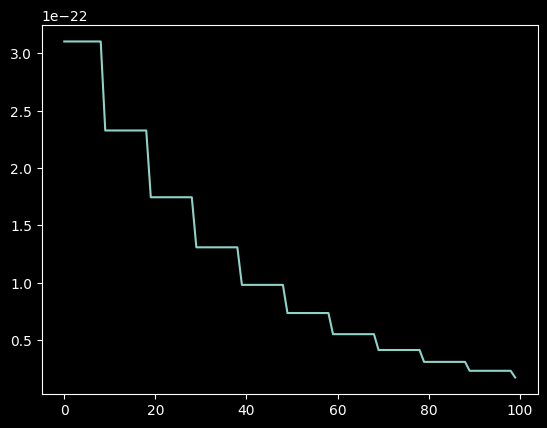

In [33]:
# milestones = [x for x in range(10,100,10)]
# print(f'Эпохи на которых изменится LR: {milestones}')

lr_scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=10, gamma=0.75)

# Подобие цикла обучения
MyList = []
for epoch in range(100):

    # Train
    for _ in range(1):
        # forward pass
        # backward pass
        opt.step()


    # Validation
        # forward pass

    lr_scheduler.step()
    lr = lr_scheduler.get_last_lr()
    MyList.append(lr)

plt.plot(MyList)
plt.show()

#### [ExponentialLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ExponentialLR.html#exponentiallr)

`ExponentialLR` - это планировщик скорости обучения в PyTorch, который уменьшает скорость обучения экспоненциально на каждой эпохе. В отличие от `StepLR`, который уменьшает скорость обучения ступенчато, `ExponentialLR` обеспечивает более плавное уменьшение.

**Как он работает?**

`ExponentialLR` обновляет скорость обучения по следующей формуле:

```
new_lr = lr * gamma ** epoch
```

где:

* `new_lr`: Новая скорость обучения.
* `lr`: Текущая скорость обучения.
* `gamma`: Множитель, определяющий скорость уменьшения. Должен быть числом между 0 и 1.  Чем ближе `gamma` к 0, тем быстрее уменьшается скорость обучения.
* `epoch`: Номер текущей эпохи (начинается с 0).
* `last_epoch`:  указывает начальную эпоху. Полезно при возобновлении тренировки. По умолчанию равно -1.


**Преимущества ExponentialLR:**

* **Плавное уменьшение:** Обеспечивает более плавное уменьшение скорости обучения по сравнению со ступенчатым уменьшением.  Это может помочь избежать резких скачков в процессе обучения и улучшить сходимость.
* **Простота:** Легко использовать и настраивать, требуется только один параметр `gamma`.


**Когда использовать ExponentialLR:**

* **Плавная сходимость:** Когда требуется плавное уменьшение скорости обучения для более стабильной сходимости.
* **Тонкая настройка:** Может быть полезен для тонкой настройки модели, когда требуется постепенно уменьшать скорость обучения для достижения наилучшего результата.  


**Недостатки:**

* **Быстрое уменьшение в начале:**  В начале обучения скорость обучения может уменьшаться слишком быстро, особенно если `gamma` слишком мал.
* **Ручная настройка:** Требует ручного подбора параметра `gamma`.


**В заключение:** `ExponentialLR` - это простой и эффективный планировщик скорости обучения, который обеспечивает плавное экспоненциальное уменьшение. Он может быть полезен во многих задачах, где требуется более плавная сходимость, но важно правильно подобрать параметр `gamma`, чтобы избежать слишком быстрого уменьшения скорости обучения в начале.


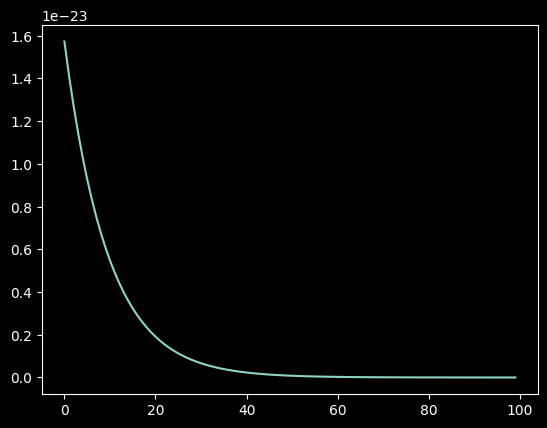

In [34]:
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.9)

# Подобие цикла обучения
MyList = []
for epoch in range(100):

    # Train
    for _ in range(1):
        # forward pass
        # backward pass
        opt.step()


    # Validation
        # forward pass

    lr_scheduler.step()
    lr = lr_scheduler.get_last_lr()
    MyList.append(lr)

plt.plot(MyList)
plt.show()

вах какой красивый график)


#### [ReduceLROnPlateau](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html#torch.optim.lr_scheduler.ReduceLROnPlateau)

`ReduceLROnPlateau` - это планировщик скорости обучения в PyTorch, который уменьшает скорость обучения, когда метрика, которую вы отслеживаете, перестает улучшаться. В отличие от планировщиков, основанных на количестве эпох, `ReduceLROnPlateau` реагирует на динамику обучения модели.

**Как он работает?**

`ReduceLROnPlateau` отслеживает заданную метрику (например, значение функции потерь на валидационном наборе) и уменьшает скорость обучения, если метрика не улучшается в течение определенного количества эпох (`patience`).

Основные параметры:

* `optimizer`: Оптимизатор, для которого нужно изменять скорость обучения.
* `mode`:  'min' (по умолчанию) - уменьшать learning rate, когда метрика перестает уменьшаться; 'max' - уменьшать, когда метрика перестает увеличиваться.
* `factor`: Множитель, на который будет умножена текущая скорость обучения при срабатывании условия.  Обычно меньше 1 (например, 0.1).
* `patience`: Количество эпох, в течение которых метрика может не улучшаться, прежде чем скорость обучения будет уменьшена.
* `threshold`: Порог для определения улучшения. Улучшение считается значимым, если разница между текущим и предыдущим значением метрики больше `threshold` * `threshold_mode`.
* `threshold_mode`:  'rel' (по умолчанию) -  `threshold` трактуется как относительное изменение; 'abs' -  `threshold` трактуется как абсолютное изменение.
* `cooldown`: Количество эпох, в течение которых скорость обучения не будет уменьшаться после последнего уменьшения.
* `min_lr`: Минимальное значение скорости обучения.
* `eps`:  Минимальное значение изменения метрики, которое считается значимым (для предотвращения деления на ноль). По умолчанию 1e-8.
* `verbose`:  Если `True`, выводить информацию об изменении скорости обучения.

**Преимущества ReduceLROnPlateau:**

* **Адаптивность:** Автоматически подстраивает скорость обучения под динамику обучения, уменьшая ее только когда это необходимо.
* **Улучшение сходимости:**  Может помочь избежать переобучения и улучшить сходимость модели, так как позволяет модели дольше обучаться с более высокой скоростью обучения, пока это приводит к улучшению метрики.

**Когда использовать ReduceLROnPlateau:**

* **Неизвестное количество эпох:**  Когда заранее неизвестно, сколько эпох потребуется для обучения модели.
* **Автоматическая настройка:** Когда хочется автоматизировать процесс настройки скорости обучения.
* **Сложные задачи:**  В сложных задачах, где ручная настройка скорости обучения может быть затруднительна.


**Недостатки:**

* **Выбор метрики:**  Требует выбора подходящей метрики для отслеживания. Неправильный выбор метрики может привести к нежелательному поведению планировщика.
* **Зависимость от валидационного набора:**  Эффективность планировщика зависит от качества валидационного набора.


**В заключение:** `ReduceLROnPlateau` - это мощный и адаптивный планировщик скорости обучения, который может значительно упростить процесс обучения модели. Он  особенно полезен в ситуациях, когда сложно заранее определить оптимальную стратегию изменения скорости обучения.  Однако, важно помнить о необходимости правильного выбора метрики и качественного валидационного набора для достижения наилучших результатов.


In [60]:
model = MyModel(784, 10)

loss_model = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr = 0.1)

In [61]:
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt,
                                                          mode='min',
                                                          factor=0.1,
                                                          patience=5,
                                                          threshold=0.0001,
                                                          threshold_mode='rel',
                                                          cooldown=0,
                                                          min_lr=0,
                                                          eps=1e-8
                                                          )

In [62]:
loss = torch.full([5, 10], 0.1)
loss = loss * torch.tensor([1/i for i in range(1,6)]).reshape([5, 1])
loss = loss.reshape([50])

In [63]:
# Подобие цикла обучения
MyList = []
for epoch in range(50):

    # Train
    for _ in range(1):
        # forward pass
        # backward pass
        opt.step()


    # Validation
        # forward pass
    idx = epoch
    lr_scheduler.step(loss[idx])

    lr = lr_scheduler._last_lr[0]
    MyList.append(lr)

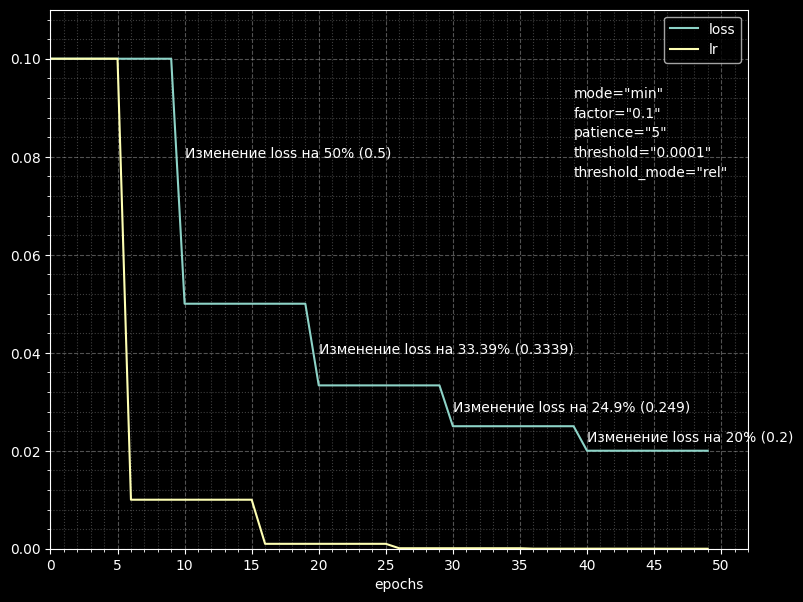

In [64]:
# Отображение графика
fig, ax = plt.subplots(figsize=(9,7))

ax.plot(loss)
ax.plot(MyList)

ax.set_xlim(0, 52)
ax.set_ylim(0, 0.11)

ax.xaxis.set_major_locator(MultipleLocator(5))

ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.yaxis.set_minor_locator(AutoMinorLocator(5))

ax.grid(which='major', color='#CCCCCC', linestyle='--', alpha=0.4)
ax.grid(which='minor', color='#CCCCCC', linestyle=':', alpha=0.3)

ax.legend(['loss', 'lr'])
ax.set_xlabel('epochs')

if lr_scheduler.threshold_mode == 'abs':
    ax.text(10, 0.08, 'Изменение loss на 0.05')
    ax.text(20, 0.04, 'Изменение loss на 0.00167')
    ax.text(30, 0.028, 'Изменение loss на 0.008')
    ax.text(40, 0.022, 'Изменение loss на 0.005')
else:
    ax.text(10, 0.08, 'Изменение loss на 50% (0.5)')
    ax.text(20, 0.04, 'Изменение loss на 33.39% (0.3339)')
    ax.text(30, 0.028, 'Изменение loss на 24.9% (0.249)')
    ax.text(40, 0.022, 'Изменение loss на 20% (0.2)')

ax.text(39, 0.092, f'mode="{lr_scheduler.mode}"')
ax.text(39, 0.088, f'factor="{lr_scheduler.factor}"')
ax.text(39, 0.084, f'patience="{lr_scheduler.patience}"')
ax.text(39, 0.080, f'threshold="{lr_scheduler.threshold}"')
ax.text(39, 0.076, f'threshold_mode="{lr_scheduler.threshold_mode}"')

plt.show()

### Задача Регрессии

In [67]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [68]:
class DatasetReg(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.transform = transform

        self.list_name_file = os.listdir(path)
        if 'coords.json' in self.list_name_file:
            self.list_name_file.remove('coords.json')

        self.len_dataset = len(self.list_name_file)

        with open(os.path.join(self.path, 'coords.json'), 'r') as f:
            self.dict_coords = json.load(f)

    def __len__(self):
        return self.len_dataset

    def __getitem__(self, index):
        name_file = self.list_name_file[index]
        path_img = os.path.join(self.path, name_file)

        img = Image.open(path_img)
        coord = self.dict_coords[name_file]

        if self.transform:
            img = self.transform(img)
            coord = torch.tensor(coord, dtype=torch.float32)


        return img, coord

In [69]:
transform = v2.Compose(
    [
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=(0.5, ), std=(0.5, ))
    ]
)

In [70]:
dataset = DatasetReg(path='/content/dataset', transform=transform)

Coord = tensor([42., 37.])


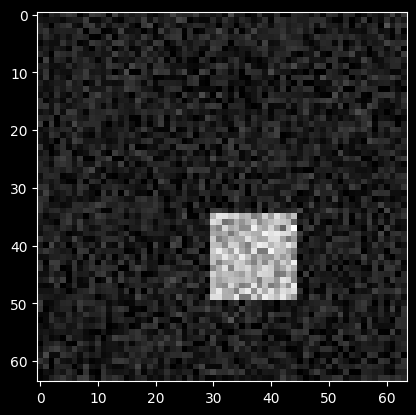

In [71]:
img, coord = dataset[2512]

print(f'Coord = {coord}')
plt.imshow(img.numpy()[0], cmap='gray')

In [72]:
train_set, val_set, test_set = random_split(dataset, [0.7, 0.1, 0.2])

In [73]:
train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
val_loader = DataLoader(val_set, batch_size=16, shuffle=False)
test_loader = DataLoader(test_set, batch_size=16, shuffle=False)

#### Создание модели для задачи регресии

In [74]:
class MyModel(nn.Module):
    def __init__(self, input, output):
        super().__init__()
        self.layer_1 = nn.Linear(input, 128)
        self.layer_2 = nn.Linear(128, output)
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.layer_1(x)
        x = self.act(x)
        out = self.layer_2(x)
        return out

In [75]:
# создаем и отправляем на cuda
model = MyModel(64*64, 2).to(device)

In [76]:
# Проверяем правильность построения модели
input = torch.rand([16, 64*64], dtype=torch.float32).to(device)

out = model(input)
out.shape    # (16,2)

torch.Size([16, 2])

In [78]:
# выбираем функцию потерь и оптимизатор градиентного спуска
loss_model = nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr=0.001)

lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt,
                                                          mode='min',
                                                          factor=0.1,
                                                          patience=5)

#### Цикл обучения

In [79]:
EPOCHS = 60
train_loss = []
train_acc = []
val_loss = []
val_acc = []
lr_list = []

In [80]:
# Цикл обучения
for epoch in range(EPOCHS):

    # 1. Тренировка модели
    model.train()
    running_train_loss = []
    true_answer = 0
    # добавим трейн луп, чтобы видеть прогресс обучения модели
    train_loop = tqdm(train_loader, leave=False)
    for x, targets in train_loop:
        # - Данные
        # (batch.size, 1, 64, 64) --> (batch.size, 64*64)
        x = x.reshape(-1, 64*64).to(device)
        targets = targets.to(device)

        # - Прямой проход + расчет ошибки модели
        pred = model(x)
        loss = loss_model(pred, targets)

        # - Обратный проход
        opt.zero_grad()
        loss.backward()
        # - Шаг оптимизации
        opt.step()

        running_train_loss.append(loss.item())
        mean_train_loss = sum(running_train_loss)/len(running_train_loss)

        true_answer += (torch.round(pred) == targets).all(dim=1).sum().item()

        train_loop.set_description(f"Epoch [{epoch+1}/{EPOCHS}], train_loss={mean_train_loss:.4f}")


    # 2. Расчет значения метрики
    running_train_acc = true_answer / len(train_set)

    # 3. Сохранение значения функции потерь и метрики
    train_loss.append(mean_train_loss)
    train_acc.append(running_train_acc)

    # 4. Проверка модели (Валидация)
    model.eval()
    with torch.no_grad():
        running_val_loss = []
        true_answer = 0
        for x, targets in val_loader:
            # - Данные
            # (batch.size, 1, 64, 64) --> (batch.size, 64*64)
            x = x.reshape(-1, 64*64).to(device)
            targets = targets.to(device)

            # - Прямой проход + расчет ошибки модели
            pred = model(x)
            loss = loss_model(pred, targets)

            running_val_loss.append(loss.item())
            mean_val_loss = sum(running_val_loss)/len(running_val_loss)

            true_answer += (torch.round(pred) == targets).all(dim=1).sum().item()

        # 2. Расчет значения метрики
        running_val_acc = true_answer / len(val_set)

        # 3. Сохранение значения функции потерь и метрики
        val_loss.append(mean_val_loss)
        val_acc.append(running_val_acc)

    lr_scheduler.step(mean_val_loss)
    lr = lr_scheduler._last_lr[0]
    lr_list.append(lr)

    print(f"Epoch [{epoch+1}/{EPOCHS}], train_loss={mean_train_loss:.4f}, train_acc={running_train_acc:.4f}, val_loss={mean_val_loss:.4f}, val_acc={running_val_acc:.4f}, lr={lr:.4f}")

Epoch [1/60], train_loss=1.7596, train_acc=0.6293, val_loss=0.1230, val_acc=0.7151, lr=0.0010


Epoch [2/60], train_loss=0.1445, train_acc=0.6656, val_loss=0.0685, val_acc=0.8933, lr=0.0010


Epoch [3/60], train_loss=0.1191, train_acc=0.7337, val_loss=0.0828, val_acc=0.8445, lr=0.0010


Epoch [4/60], train_loss=0.1047, train_acc=0.7803, val_loss=0.1226, val_acc=0.7236, lr=0.0010


Epoch [5/60], train_loss=0.0893, train_acc=0.8253, val_loss=0.0729, val_acc=0.8848, lr=0.0010


Epoch [6/60], train_loss=0.0822, train_acc=0.8493, val_loss=0.1518, val_acc=0.6591, lr=0.0010


Epoch [7/60], train_loss=0.0769, train_acc=0.8671, val_loss=0.0691, val_acc=0.9066, lr=0.0010


Epoch [8/60], train_loss=0.0696, train_acc=0.8914, val_loss=0.0835, val_acc=0.8393, lr=0.0001


Epoch [9/60], train_loss=0.0352, train_acc=0.9834, val_loss=0.0492, val_acc=0.9542, lr=0.0001


Epoch [10/60], train_loss=0.0353, train_acc=0.9827, val_loss=0.0365, val_acc=0.9776, lr=0.0001


Epoch [11/60], train_loss=0.0348, train_acc=0.9837, val_loss=0.0396, val_acc=0.9740, lr=0.0001


Epoch [12/60], train_loss=0.0342, train_acc=0.9847, val_loss=0.0412, val_acc=0.9673, lr=0.0001


Epoch [13/60], train_loss=0.0334, train_acc=0.9854, val_loss=0.0340, val_acc=0.9829, lr=0.0001


Epoch [14/60], train_loss=0.0327, train_acc=0.9871, val_loss=0.0405, val_acc=0.9730, lr=0.0001


Epoch [15/60], train_loss=0.0317, train_acc=0.9882, val_loss=0.0342, val_acc=0.9831, lr=0.0001


Epoch [16/60], train_loss=0.0311, train_acc=0.9895, val_loss=0.0402, val_acc=0.9733, lr=0.0001


Epoch [17/60], train_loss=0.0305, train_acc=0.9905, val_loss=0.0325, val_acc=0.9856, lr=0.0001


Epoch [18/60], train_loss=0.0298, train_acc=0.9909, val_loss=0.0329, val_acc=0.9842, lr=0.0001


Epoch [19/60], train_loss=0.0293, train_acc=0.9918, val_loss=0.0331, val_acc=0.9849, lr=0.0001


Epoch [20/60], train_loss=0.0289, train_acc=0.9923, val_loss=0.0385, val_acc=0.9774, lr=0.0001


Epoch [21/60], train_loss=0.0290, train_acc=0.9924, val_loss=0.0303, val_acc=0.9879, lr=0.0001


Epoch [22/60], train_loss=0.0280, train_acc=0.9935, val_loss=0.0304, val_acc=0.9884, lr=0.0001


Epoch [23/60], train_loss=0.0279, train_acc=0.9935, val_loss=0.0292, val_acc=0.9895, lr=0.0001


Epoch [24/60], train_loss=0.0277, train_acc=0.9930, val_loss=0.0372, val_acc=0.9799, lr=0.0001


Epoch [25/60], train_loss=0.0274, train_acc=0.9939, val_loss=0.0338, val_acc=0.9836, lr=0.0001


Epoch [26/60], train_loss=0.0270, train_acc=0.9945, val_loss=0.0309, val_acc=0.9876, lr=0.0001


Epoch [27/60], train_loss=0.0272, train_acc=0.9937, val_loss=0.0297, val_acc=0.9891, lr=0.0001


Epoch [28/60], train_loss=0.0268, train_acc=0.9946, val_loss=0.0323, val_acc=0.9868, lr=0.0001


Epoch [29/60], train_loss=0.0264, train_acc=0.9949, val_loss=0.0320, val_acc=0.9860, lr=0.0000


Epoch [30/60], train_loss=0.0227, train_acc=0.9976, val_loss=0.0276, val_acc=0.9917, lr=0.0000


Epoch [31/60], train_loss=0.0227, train_acc=0.9974, val_loss=0.0274, val_acc=0.9919, lr=0.0000


Epoch [32/60], train_loss=0.0226, train_acc=0.9977, val_loss=0.0278, val_acc=0.9916, lr=0.0000


Epoch [33/60], train_loss=0.0226, train_acc=0.9976, val_loss=0.0274, val_acc=0.9916, lr=0.0000


Epoch [34/60], train_loss=0.0225, train_acc=0.9977, val_loss=0.0282, val_acc=0.9911, lr=0.0000


Epoch [35/60], train_loss=0.0225, train_acc=0.9976, val_loss=0.0286, val_acc=0.9903, lr=0.0000


Epoch [36/60], train_loss=0.0225, train_acc=0.9976, val_loss=0.0275, val_acc=0.9917, lr=0.0000


Epoch [37/60], train_loss=0.0224, train_acc=0.9979, val_loss=0.0275, val_acc=0.9917, lr=0.0000


Epoch [38/60], train_loss=0.0220, train_acc=0.9979, val_loss=0.0272, val_acc=0.9921, lr=0.0000


Epoch [39/60], train_loss=0.0219, train_acc=0.9979, val_loss=0.0272, val_acc=0.9921, lr=0.0000


Epoch [40/60], train_loss=0.0219, train_acc=0.9980, val_loss=0.0271, val_acc=0.9920, lr=0.0000


Epoch [41/60], train_loss=0.0219, train_acc=0.9980, val_loss=0.0272, val_acc=0.9920, lr=0.0000


Epoch [42/60], train_loss=0.0219, train_acc=0.9978, val_loss=0.0271, val_acc=0.9919, lr=0.0000


Epoch [43/60], train_loss=0.0219, train_acc=0.9980, val_loss=0.0271, val_acc=0.9918, lr=0.0000


Epoch [44/60], train_loss=0.0219, train_acc=0.9980, val_loss=0.0273, val_acc=0.9921, lr=0.0000


Epoch [45/60], train_loss=0.0219, train_acc=0.9979, val_loss=0.0271, val_acc=0.9918, lr=0.0000


Epoch [46/60], train_loss=0.0219, train_acc=0.9980, val_loss=0.0271, val_acc=0.9918, lr=0.0000


Epoch [47/60], train_loss=0.0219, train_acc=0.9979, val_loss=0.0271, val_acc=0.9918, lr=0.0000


Epoch [48/60], train_loss=0.0219, train_acc=0.9980, val_loss=0.0271, val_acc=0.9919, lr=0.0000


Epoch [49/60], train_loss=0.0219, train_acc=0.9980, val_loss=0.0271, val_acc=0.9918, lr=0.0000


Epoch [50/60], train_loss=0.0219, train_acc=0.9980, val_loss=0.0271, val_acc=0.9918, lr=0.0000


Epoch [51/60], train_loss=0.0219, train_acc=0.9979, val_loss=0.0271, val_acc=0.9918, lr=0.0000


Epoch [52/60], train_loss=0.0219, train_acc=0.9980, val_loss=0.0271, val_acc=0.9917, lr=0.0000


Epoch [53/60], train_loss=0.0219, train_acc=0.9980, val_loss=0.0271, val_acc=0.9918, lr=0.0000


Epoch [54/60], train_loss=0.0219, train_acc=0.9979, val_loss=0.0271, val_acc=0.9919, lr=0.0000


Epoch [55/60], train_loss=0.0219, train_acc=0.9980, val_loss=0.0271, val_acc=0.9917, lr=0.0000


Epoch [56/60], train_loss=0.0219, train_acc=0.9980, val_loss=0.0271, val_acc=0.9920, lr=0.0000


Epoch [57/60], train_loss=0.0219, train_acc=0.9979, val_loss=0.0272, val_acc=0.9920, lr=0.0000


Epoch [58/60], train_loss=0.0219, train_acc=0.9981, val_loss=0.0272, val_acc=0.9919, lr=0.0000


Epoch [59/60], train_loss=0.0218, train_acc=0.9980, val_loss=0.0271, val_acc=0.9918, lr=0.0000


Epoch [60/60], train_loss=0.0218, train_acc=0.9980, val_loss=0.0271, val_acc=0.9917, lr=0.0000


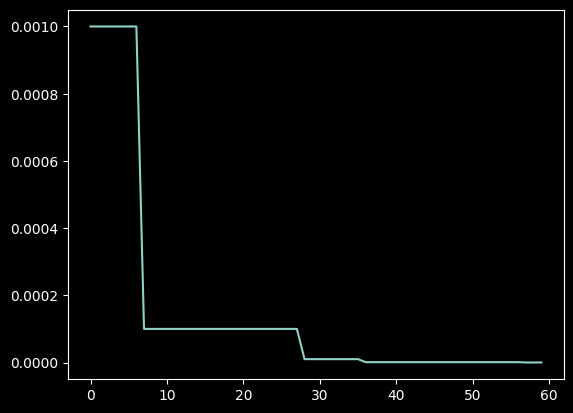

In [81]:
plt.plot(lr_list)
plt.show()

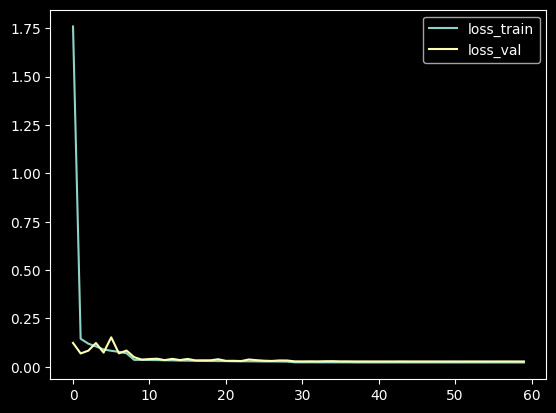

In [83]:
plt.plot(train_loss)
plt.plot(val_loss)
plt.legend(['loss_train', 'loss_val'])
plt.show()

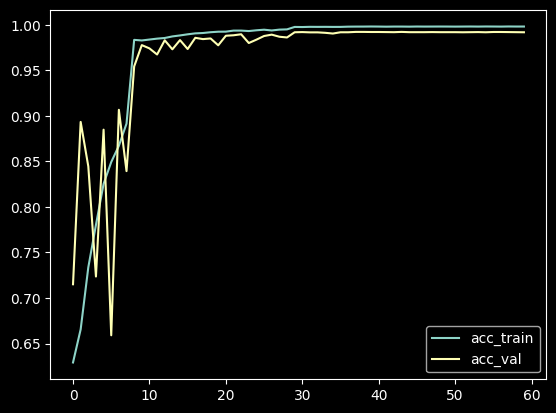

In [84]:
plt.plot(train_acc)
plt.plot(val_acc)
plt.legend(['acc_train', 'acc_val'])
plt.show()

В целом, из графиков видно, что обучение можно было остановить на тридцатой эпохе.

Все это благодаря шедулеру =)